In [19]:
import numpy as np
import pandas as pd
import random
import os
import gc
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from keras.models import Sequential
import datetime as dt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint, TensorBoard
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler

In [20]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
#import lstm, time #helper libraries

In [21]:
data = pd.read_csv("outputs/194.csv")

In [22]:
data

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,-0.167222,-0.220092,-2.146413,1.085153,-0.580143,-0.636593,0.960789,-1.163073,1.723667,0.114809,...,-0.170365,-1.095620,-0.845827,-1.220772,0.941183,-0.697923,0.104928,1.301459,-1.528616,-0.874732
1,0.497589,-0.218475,-1.926347,1.061314,-0.608431,-0.626403,0.129537,-1.051303,1.777281,0.165132,...,0.693888,-1.081652,-0.678997,-1.721066,-1.189598,-0.685752,-1.173816,-0.460874,-1.796684,-0.881867
2,0.131961,0.382625,-1.721470,1.010066,-0.595838,-0.625392,-0.264190,-0.947957,1.797179,0.138120,...,0.444662,-1.283087,-1.285356,-1.362706,-1.410982,-0.605276,0.083176,-0.537239,-1.632431,-0.855995
3,-0.407528,0.431602,-1.488228,0.830175,-0.528608,-0.618583,-1.398601,-0.845484,1.888197,0.080987,...,0.822857,0.791741,-1.715823,-1.304561,0.442616,-0.754237,-1.073166,0.046805,-1.679083,-0.817206
4,-0.028724,0.517307,-1.272062,1.161706,-0.516323,-0.632842,-1.272502,-0.704417,1.921564,0.165095,...,0.466347,-0.582876,-1.638609,-2.130669,-0.569905,-0.879612,0.675597,-0.028204,-1.575315,-0.863082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1.321046,0.382402,-0.693653,-0.876491,-0.428748,-0.212334,-0.277083,0.656136,2.197620,0.086913,...,0.761155,-0.694756,-0.717541,0.769126,-1.033787,-0.648952,-0.082722,-0.052041,-1.579982,-0.691136
1216,-0.206059,0.604906,-0.786892,-0.786426,-0.450898,-0.214482,-0.035429,0.030516,2.213227,0.145693,...,-0.831445,-0.730822,-0.877125,-1.161238,-1.164095,-0.611996,0.944268,-0.530056,-1.469723,-0.682624
1217,0.477665,0.380139,-0.594073,-0.663436,-0.368767,-0.212187,0.149785,-0.799389,2.223244,0.123488,...,-1.475681,0.605606,-0.860753,0.405561,0.675163,-0.506055,1.959251,1.937853,0.654362,-0.693283
1218,1.237748,0.409795,-0.211851,-0.788017,-0.423646,-0.215945,-0.015050,-1.449756,2.226181,0.063720,...,-0.437745,-0.819054,-1.081574,0.482149,0.967866,-0.522155,-1.386759,2.584658,-1.233330,-0.700759


In [23]:
#train = data.iloc[0:1200,:]
#test = data.iloc[1200:1220,:]
train = pd.read_csv("outputs/filled_train_data194_PCA09.csv")
test = pd.read_csv("outputs/filled_test_data194_PCA09.csv")
#test

### Below we finish the min man scale

In [24]:
train_X  = train.loc[:,train.columns != 'target']
scaler = MinMaxScaler().fit(train_X)
scaled = scaler.transform(train_X)
train_X = pd.DataFrame(scaled,columns= train_X.columns)
train_X = np.array(train_X)
train_y = train.loc[:,train.columns =="target"]
scaler = MinMaxScaler().fit(train_y)
scaled = scaler.transform(train_y)
train_y = pd.DataFrame(scaled,columns= train_y.columns)
train_y = np.array(train_y)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [25]:
#
test_X  = test.loc[:,test.columns != 'target']
scaler = MinMaxScaler().fit(test_X)
scaled = scaler.transform(test_X)
test_X = pd.DataFrame(scaled,columns= test_X.columns)
test_X = np.array(test_X)
test_y = test.loc[:,test.columns =="target"]
scaler = MinMaxScaler().fit(test_y)
scaled = scaler.transform(test_y)
test_y = pd.DataFrame(scaled,columns= test_y.columns)
test_y = np.array(test_y)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [123]:
train_X

array([[[0.69482345, 0.24944412, 0.58380407, ..., 0.58387156,
         0.24727695, 0.22270436]],

       [[0.69497011, 0.27800462, 0.57967598, ..., 0.43644711,
         0.20637687, 0.21626432]],

       [[0.7494931 , 0.30459396, 0.57080159, ..., 0.43005896,
         0.2314375 , 0.239618  ]],

       ...,

       [[0.65447653, 0.12739177, 0.47888533, ..., 0.4505543 ,
         0.38064019, 0.4202871 ]],

       [[0.63054308, 0.162183  , 0.47284637, ..., 0.37058134,
         0.40105773, 0.44871509]],

       [[0.71146471, 0.26339292, 0.47946918, ..., 0.47144588,
         0.3559774 , 0.3985474 ]]])

In [125]:
#test = data.iloc[1200:1220,:]

In [126]:
#test

In [155]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train)
scaled = scaler.transform(train)
train = pd.DataFrame(scaled,columns= train.columns)

In [156]:
train

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.485441,0.694823,0.249444,0.583804,0.224014,0.272345,0.733449,0.349901,0.368842,0.250164,...,0.540341,0.543921,0.421182,0.724581,0.601922,0.847793,0.515407,0.583872,0.247277,0.222704
1,0.591504,0.694970,0.278005,0.579676,0.218269,0.284960,0.616695,0.365161,0.382352,0.307558,...,0.639095,0.545728,0.440012,0.691343,0.354078,0.850344,0.322437,0.436447,0.206377,0.216264
2,0.533172,0.749493,0.304594,0.570802,0.220826,0.286212,0.561393,0.379270,0.387365,0.276751,...,0.610617,0.519670,0.371572,0.715151,0.328328,0.867211,0.512124,0.430059,0.231438,0.239618
3,0.447103,0.753936,0.334865,0.539651,0.234479,0.294642,0.402058,0.393261,0.410300,0.211590,...,0.653832,0.788073,0.322985,0.719014,0.543931,0.835989,0.337626,0.478916,0.224320,0.274631
4,0.507537,0.761709,0.362919,0.597061,0.236974,0.276988,0.419770,0.412520,0.418708,0.307516,...,0.613095,0.610250,0.331700,0.664130,0.426158,0.809710,0.601524,0.472641,0.240152,0.233221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.462801,0.738763,0.024977,0.593949,0.163593,0.763381,0.473197,0.379846,0.589114,0.141409,...,0.574771,0.610597,0.251534,0.537613,0.425597,0.838492,0.599455,0.472433,0.386175,0.381545
1196,0.476270,0.652406,0.048434,0.478938,0.207937,0.757152,0.470693,0.446403,0.490725,0.129183,...,0.573508,0.629666,0.196578,0.509134,0.357205,0.788866,0.412219,0.395863,0.381671,0.380576
1197,0.440164,0.654477,0.127392,0.478885,0.148714,0.738342,0.631279,0.421050,0.506472,0.155283,...,0.446986,0.628079,0.341361,0.494497,0.490183,0.842066,0.722535,0.450554,0.380640,0.420287
1198,0.664513,0.630543,0.162183,0.472846,0.156578,0.736670,0.660509,0.419996,0.655889,0.235713,...,0.560550,0.544651,0.372499,0.553817,0.045534,0.822370,0.580398,0.370581,0.401058,0.448715


In [159]:
scaler = MinMaxScaler().fit(test)
scaled = scaler.transform(test)
test = pd.DataFrame(scaled,columns= test.columns)

In [160]:
test

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.321180,0.363399,0.000000,0.843296,0.590458,0.174558,0.537944,0.239693,0.131528,0.684932,...,0.836101,0.142082,0.000000,0.890871,0.322665,0.001238,0.090803,0.138162,0.225899,0.054906
1,0.535595,0.732538,0.225611,0.834829,0.149450,0.436670,0.564469,0.094634,0.000000,0.336242,...,0.428837,0.648616,0.633322,1.000000,0.626408,0.458138,0.371784,0.504904,0.142206,0.182780
2,0.518567,0.702891,0.295907,1.000000,0.049675,0.323784,0.940390,0.011151,0.615828,0.166567,...,0.896672,0.093559,0.335567,0.841141,0.054346,0.724919,0.215156,0.331854,0.170972,0.000000
3,0.588952,0.799690,0.285489,0.876060,0.133831,0.712575,0.700387,0.147907,0.522101,0.735321,...,0.881467,0.201062,0.634606,0.911510,0.439639,0.587869,0.412554,0.393401,0.086735,0.733904
4,0.623914,1.000000,0.153442,0.957747,0.215064,0.990837,0.900722,0.436839,0.774713,0.240670,...,0.566431,0.281079,0.399967,0.871147,0.706362,0.425138,0.499170,0.306919,0.056864,0.497701
5,0.352340,0.764397,0.413838,0.841009,0.000000,1.000000,1.000000,0.769996,1.000000,0.600479,...,0.714783,0.334971,0.448473,0.935733,0.559565,0.000000,0.651300,0.244658,0.000000,0.216280
6,0.405270,0.755899,0.495362,0.575013,0.439371,0.756534,0.845502,0.788988,0.803414,0.519906,...,0.396612,0.341338,0.427213,0.614059,0.449975,0.323929,0.702391,0.095644,0.163048,0.821868
7,0.461165,0.638145,0.629395,0.818211,0.338669,0.273369,0.573801,1.000000,0.779607,0.599222,...,0.626208,0.353041,0.245737,0.706759,0.440983,0.628805,0.871513,0.242099,0.389774,0.835069
8,0.641662,0.529957,1.000000,0.831490,0.429043,0.000000,0.378637,0.659579,0.229728,0.592833,...,0.426595,0.235125,0.537198,0.843991,0.665470,0.570453,0.708186,0.000000,0.217444,0.898093
9,0.788253,0.664316,0.927342,0.770056,0.275672,0.203476,0.670270,0.398862,0.402818,1.000000,...,0.370938,0.000000,0.797637,0.763699,0.959122,0.379804,1.000000,0.289572,0.397006,1.000000


### demo prediction here

In [167]:
model = Sequential()
model.add(LSTM(50,activation='relu',batch_input_shape=(1200, train_X.shape[1], train_X.shape[2]),stateful=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [168]:
model.fit(train_X, train_y, epochs=20, batch_size=1200, verbose=0, shuffle=False)

In [258]:

from keras.models import load_model

In [259]:
model.save('LA.h5')
#pickle.dump(model, open('LA.pkl', 'wb'))

In [205]:
del model

In [206]:
model = load_model('LA.h5')

In [169]:
pred = model.predict(train_X,batch_size=1200)

In [108]:
time_id = []
for i in range(1200):
    time_id.append(i)

In [109]:
len(time_id)

1200

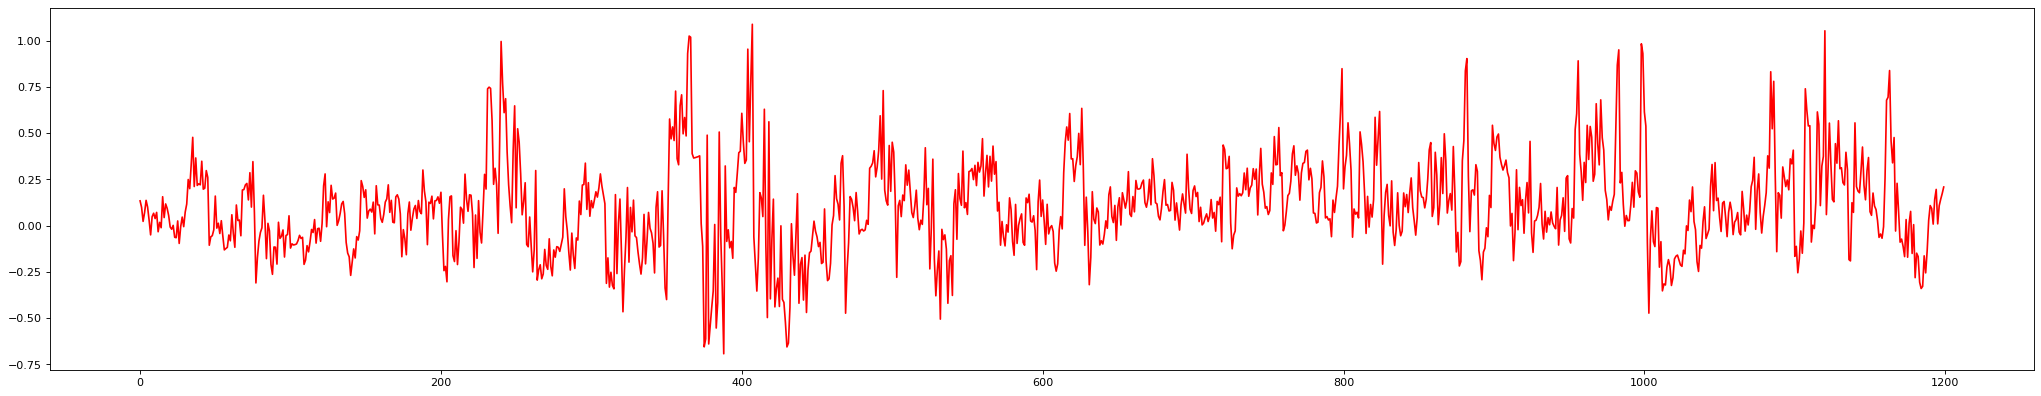

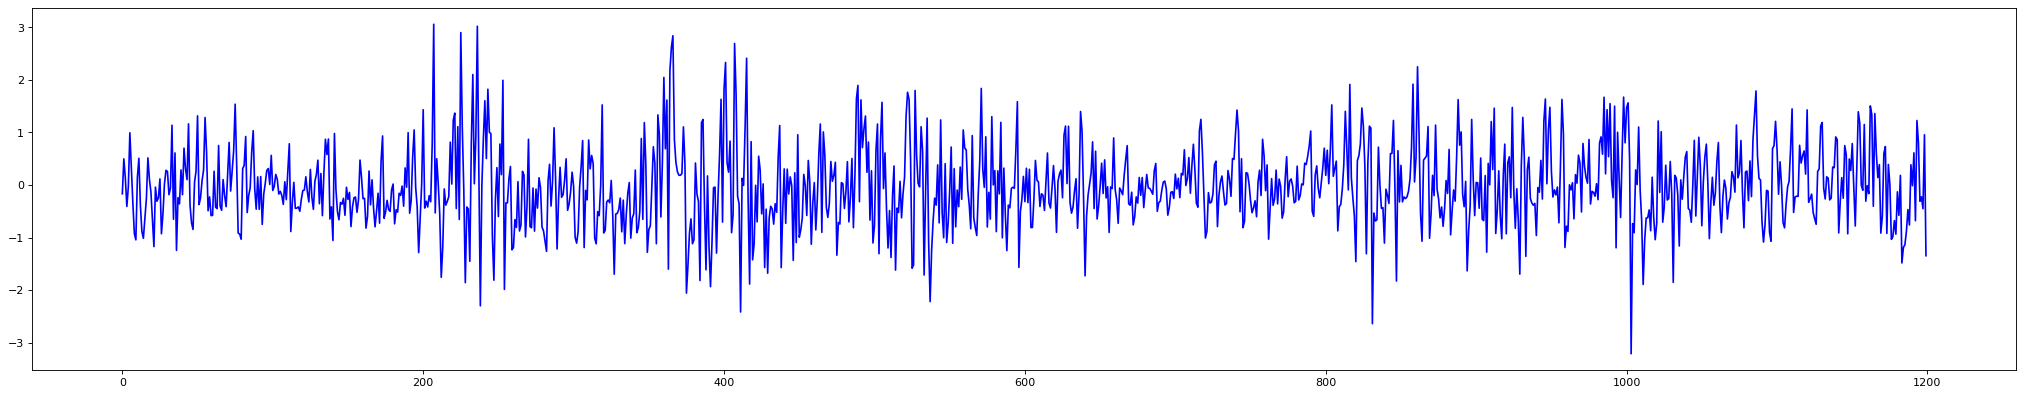

In [142]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(32, 6), dpi=80)
plt.plot(time_id,pred,color = "r")
plt.show()
figure(figsize=(32, 6), dpi=80)
plt.plot(time_id,train_y,color = "b")
plt.show()

In [170]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_y,pred)

0.03405459172718012

array([[[-0.2200923 ],
        [-2.14641285],
        [ 1.08515251],
        ...,
        [ 1.30145884],
        [-1.52861595],
        [-0.87473249]],

       [[-0.21847548],
        [-1.92634737],
        [ 1.06131351],
        ...,
        [-0.46087402],
        [-1.79668379],
        [-0.88186705]],

       [[ 0.38262492],
        [-1.72147012],
        [ 1.01006556],
        ...,
        [-0.53723896],
        [-1.63243103],
        [-0.85599482]],

       ...,

       [[ 0.38013923],
        [-0.59407252],
        [-0.663436  ],
        ...,
        [ 1.93785334],
        [ 0.6543622 ],
        [-0.69328266]],

       [[ 0.40979517],
        [-0.21185113],
        [-0.78801727],
        ...,
        [ 2.58465838],
        [-1.23333049],
        [-0.70075929]],

       [[ 0.73267043],
        [-0.06991468],
        [-0.97689134],
        ...,
        [ 2.80637836],
        [-0.18696363],
        [-0.69270647]]])

In [26]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### We tune the hyperparameter of batch_size, epochs and neurons here

Wall time: 58.6 s


<function matplotlib.pyplot.show(close=None, block=None)>

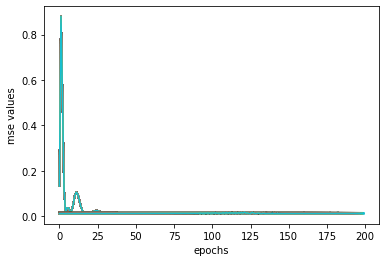

In [181]:
%%time
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, batch_input_shape=(600, train_X.shape[1], train_X.shape[2])))
model.add(LSTM(10, return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(1,activation = 'linear'))
model.compile(optimizer='adam', loss='mse')
#forj in [100,500,1000]:
from statistics import mean
mse_list = []
mse_id = []
mse_mean = []
min_mse = 1000
#model.reset_states()
plt.clf()
for j in range(1,6):
    for i in range(200):
       
       
        model.fit(train_X, train_y, epochs=1, batch_size=600, verbose=0, shuffle=False)
        mse = mean_squared_error(train_y,model.predict(train_X,batch_size=600))
        model.reset_states()
        #model.reset_states()

        #mse_mean.append(mse)
        mse_list.append(mse)
        mse_id.append(i)
        plt.plot(mse_id,mse_list)
        plt.ylabel("mse values")
        plt.xlabel("epochs")
        #figure(figsize=(32, 6), dpi=80)
    mse_list = []
    mse_id = []
    #mse_list.append(mean(mse_mean))
    #mse_id.append(j)
    #mse_mean = []


#plt.plot(mse_id,mse_list)
plt.show